In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [2]:
# load austin radar data for validation
link_to_NPMRDS_data = 'data for validation/Austin/NPMRDS/'
NPMRDS_data_file = 'austin_NPMRDS.csv'
austin_NPMRDS_data = read_csv(link_to_NPMRDS_data + NPMRDS_data_file, sep = ',')
austin_NPMRDS_data.head(5)

,Unnamed: 0,Tmc,fips,f_sys,station,dir,month,day,hour,flow_per_lane,...,mean.spd,GEOID,County,AADT,density_per_lane,StartLat,StartLong,EndLat,EndLong,Truck
0,1,112-05027,48,1,276,S,10,26,18,4269,...,38.01,2.381842e-313,Hays,121162,112.312549,30.075088,-97.826118,30.043279,-97.841784,1
1,2,112-05027,48,1,276,S,10,26,17,4381,...,39.82,2.381842e-313,Hays,121162,110.020090,30.075088,-97.826118,30.043279,-97.841784,1
2,3,112-05027,48,1,276,S,10,26,17,4381,...,39.82,2.381842e-313,Hays,121162,110.020090,30.075088,-97.826118,30.043279,-97.841784,1
3,4,112-05027,48,1,276,S,10,26,3,606,...,66.60,2.381842e-313,Hays,121162,9.099099,30.075088,-97.826118,30.043279,-97.841784,1
4,5,112-05027,48,1,276,S,10,26,18,4269,...,38.01,2.381842e-313,Hays,121162,112.312549,30.075088,-97.826118,30.043279,-97.841784,1


In [3]:
# select observed data for validation

austin_NPMRDS_data.loc[austin_NPMRDS_data['mean.spd']>= 80, 'mean.spd'] = 80

austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data.groupby(['Tmc', 'hour'])[['flow_per_lane']].mean()
austin_NPMRDS_data_hourly_volume.columns = ['Volume (veh/lane/hour)']
austin_NPMRDS_data_hourly_volume = austin_NPMRDS_data_hourly_volume.reset_index()
austin_NPMRDS_data_hourly_speed = austin_NPMRDS_data.groupby(['Tmc', 'hour']).apply(lambda x: np.average(x['mean.spd'], weights=x['flow_per_lane']))
austin_NPMRDS_data_hourly_speed = austin_NPMRDS_data_hourly_speed.reset_index()
austin_NPMRDS_data_hourly_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)']

austin_NPMRDS_data_hourly_data = pd.merge(austin_NPMRDS_data_hourly_volume,
                                         austin_NPMRDS_data_hourly_speed,
                                         on = ['Tmc', 'hour'], how = 'left')
austin_NPMRDS_data_hourly_data.head(5)

,Tmc,hour,Volume (veh/lane/hour),Avg.Speed (mph)
0,112+05028,0,841.870968,65.475275
1,112+05028,1,608.774194,66.073389
2,112+05028,2,532.870968,65.491132
3,112+05028,3,613.064516,66.043253
4,112+05028,4,931.838710,65.958479


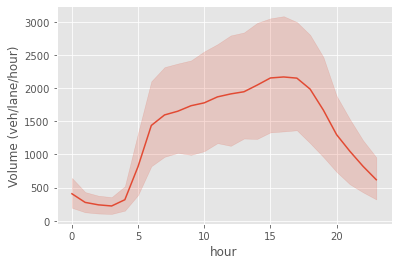

In [4]:
sns.lineplot(data = austin_NPMRDS_data_hourly_data, x = "hour", y = "Volume (veh/lane/hour)", ci=95)
# plt.ylim([0, 70])
# plt.ylabel('average speed (mph)')
plt.savefig('plot/austin_NPMRDS_hourly_mean_volume.png', bbox_inches='tight', dpi = 300)
plt.show()

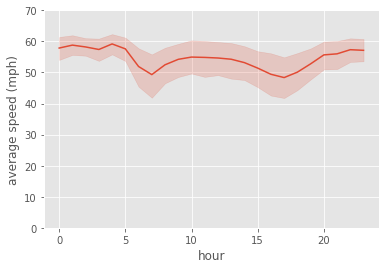

In [5]:
sns.lineplot(data = austin_NPMRDS_data_hourly_data, x = "hour", y = "Avg.Speed (mph)", ci=95)
plt.ylim([0, 70])
plt.ylabel('average speed (mph)')
plt.savefig('plot/austin_NPMRDS_hourly_mean_speed.png', bbox_inches='tight', dpi = 300)
plt.show()

In [6]:
# load BEAM output
modeled_vmt = read_csv('sample output/AUS2010/0.linkstats.csv.gz', low_memory=False)
model_network = read_csv('sample output/AUS2010/beam_network_npmrds_screenline.csv', low_memory=False)

In [7]:
meter_to_mile = 0.000621371
percent_of_samples = 0.2
mps_to_mph = 2.23694
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)

,Unnamed: 0,linkId,linkLength,length,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code,Tmc,dist_to_tmc
0,1,0,27.205,27.220564,31.963281,7500,3.0,car;bike,4358672,motorway,0,1,Williamson,14,491,112-05792,10.090094
1,2,2,134.457,134.533912,31.963281,7500,3.0,car;bike,4358673,motorway,2,3,Williamson,14,491,112P15373,0.000000
2,3,4,72.990,73.032244,31.963281,7500,3.0,car;bike,4358675,motorway,3,4,Williamson,14,491,112N15373,3.099958
3,4,6,340.382,340.578301,36.880708,7500,3.0,car;bike,4358677,motorway,5,6,Williamson,14,491,112+15647,7.912975
4,5,8,186.787,186.895207,36.880708,7500,3.0,car;bike,4358677,motorway,6,7,Williamson,14,491,112+15647,7.651479


In [8]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'inner')
model_vmt_24_hour.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,link,from,to,hour,length_x,freespeed,capacity,stat,volume,traveltime,...,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code,Tmc,dist_to_tmc
0,3640,2851,2852,5.0,102.796,22.352,1500.0,AVG,0.0,4.598962,...,car;walk;bike,15103804,trunk_link,2851,2852,Bastrop,14,21,112N06344,44.090915
1,3640,2851,2852,6.0,102.796,22.352,1500.0,AVG,0.0,4.598962,...,car;walk;bike,15103804,trunk_link,2851,2852,Bastrop,14,21,112N06344,44.090915
2,3640,2851,2852,7.0,102.796,22.352,1500.0,AVG,0.0,4.598962,...,car;walk;bike,15103804,trunk_link,2851,2852,Bastrop,14,21,112N06344,44.090915
3,3640,2851,2852,8.0,102.796,22.352,1500.0,AVG,0.0,4.598962,...,car;walk;bike,15103804,trunk_link,2851,2852,Bastrop,14,21,112N06344,44.090915
4,3640,2851,2852,9.0,102.796,22.352,1500.0,AVG,0.0,4.598962,...,car;walk;bike,15103804,trunk_link,2851,2852,Bastrop,14,21,112N06344,44.090915


In [9]:
model_vmt_24_hour = model_vmt_24_hour.rename(columns = {'length_x': 'length_raw', 
                                                        'length_y': 'length_adj'})
print(model_vmt_24_hour.columns)

Index(['link', 'from', 'to', 'hour', 'length_raw', 'freespeed', 'capacity',
       'stat', 'volume', 'traveltime', 'Unnamed: 0', 'linkId', 'linkLength',
       'length_adj', 'linkFreeSpeed', 'linkCapacity', 'numberOfLanes',
       'linkModes', 'attributeOrigId', 'attributeOrigType', 'fromNodeId',
       'toNodeId', 'name', 'txdot_abbr', 'fips_code', 'Tmc', 'dist_to_tmc'],
      dtype='object')


In [10]:
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'hourly volume'] = model_vmt_24_hour.loc[:, 'volume']/ \
model_vmt_24_hour.loc[:, 'numberOfLanes']
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600
model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']


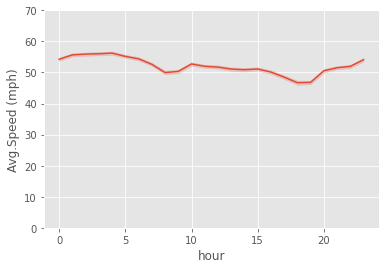

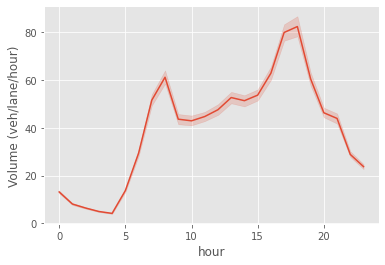

In [11]:
model_vmt_hour_volume = model_vmt_24_hour.groupby(['Tmc', 'hour'])[['hourly volume']].mean()
model_vmt_hour_volume = model_vmt_hour_volume.reset_index()
model_vmt_hour_volume.columns = ['Tmc', 'hour', 'Volume (veh/lane/hour)']
model_vmt_24_hour_filtered = model_vmt_24_hour.loc[model_vmt_24_hour['volume']>0]
model_vmt_hour_speed = model_vmt_24_hour_filtered.groupby(['Tmc', 'hour']).apply(lambda x: np.average(x.speed, weights=x.volume))
model_vmt_hour_speed = model_vmt_hour_speed.reset_index()
model_vmt_hour_speed.columns = ['Tmc', 'hour', 'Avg.Speed (mph)'] 
model_vmt_hour_speed.loc[:, 'Avg.Speed (mph)'] *= mps_to_mph

model_vmt_hour_data = pd.merge(model_vmt_hour_volume, model_vmt_hour_speed,
                               on = ['Tmc', 'hour'], how = 'left')
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', data = model_vmt_hour_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/modeled_speed_NPMRDS_screenline.png', dpi = 200)
plt.show()

sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', data = model_vmt_hour_data, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/modeled_volume_NPMRDS_screenline.png', dpi = 200)
plt.show()

In [12]:
# compare two datasets
austin_NPMRDS_data_hourly_data.loc[:, 'source'] = 'NPMRDS'
model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data = pd.concat([austin_NPMRDS_data_hourly_data, model_vmt_hour_data])
combined_data = combined_data.reset_index()
combined_data.head(5)

,index,Tmc,hour,Volume (veh/lane/hour),Avg.Speed (mph),source
0,0,112+05028,0.0,841.870968,65.475275,NPMRDS
1,1,112+05028,1.0,608.774194,66.073389,NPMRDS
2,2,112+05028,2.0,532.870968,65.491132,NPMRDS
3,3,112+05028,3.0,613.064516,66.043253,NPMRDS
4,4,112+05028,4.0,931.838710,65.958479,NPMRDS


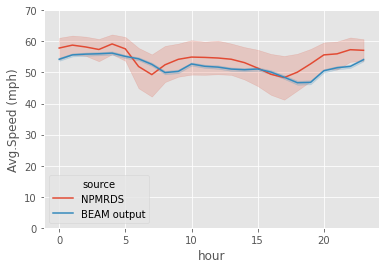

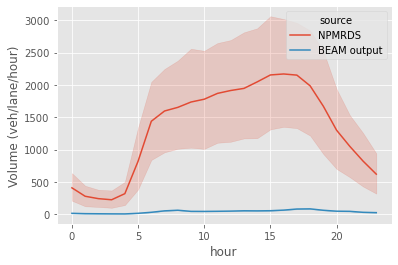

In [13]:
sns.lineplot(x = 'hour', y = 'Avg.Speed (mph)', hue = 'source', data = combined_data, ci = 95)
plt.ylim([0, 70])
plt.savefig('plot/BEAM_NPMRDS_screenline_speed_validation.png', dpi = 200)
plt.show()

sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source', data = combined_data, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/BEAM_NPMRDS_screenline_volume_validation.png', dpi = 200)
plt.show()

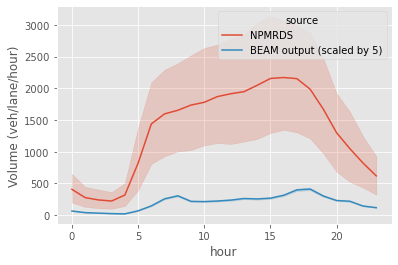

In [14]:
model_vmt_hour_data_scaled = model_vmt_hour_data.copy()
model_vmt_hour_data_scaled.loc[:, 'Volume (veh/lane/hour)'] *= 5
model_vmt_hour_data_scaled.loc[:, 'source'] = 'BEAM output (scaled by 5)'
#model_vmt_hour_data.loc[:, 'source'] = 'BEAM output'
combined_data_scaled = pd.concat([austin_NPMRDS_data_hourly_data, model_vmt_hour_data_scaled])
combined_data_scaled = combined_data_scaled.reset_index()
combined_data_scaled.head(5)
sns.lineplot(x = 'hour', y = 'Volume (veh/lane/hour)', hue = 'source', 
             data = combined_data_scaled, ci = 95)
# plt.ylim([0, 70])
# plt.ylabel('volume (veh/lane/hour)')
plt.savefig('plot/BEAM_NPMRDS_screenline_scaled_volume_validation.png', dpi = 200)
plt.show()

In [15]:
paired_data_for_comparison = pd.merge(austin_NPMRDS_data_hourly_data, model_vmt_hour_data,
                                      on = ['Tmc', 'hour'], how = 'left')
paired_data_for_comparison = paired_data_for_comparison.rename(columns = {'Avg.Speed (mph)_x': 'Austin NPMRDS speed',
                                                                         'Avg.Speed (mph)_y': 'BEAM speed',
                                                                         'Volume (veh/lane/hour)_x': 'Austin NPMRDS volume',
                                                                         'Volume (veh/lane/hour)_y': 'BEAM volume'})
# paired_data_for_comparison["KITS ID"] = paired_data_for_comparison["KITS ID"].astype(str)
paired_data_for_comparison.head(5)

,Tmc,hour,Austin NPMRDS volume,Austin NPMRDS speed,source_x,BEAM volume,BEAM speed,source_y
0,112+05028,0,841.870968,65.475275,NPMRDS,17.304348,65.566540,BEAM output
1,112+05028,1,608.774194,66.073389,NPMRDS,12.514493,67.248606,BEAM output
2,112+05028,2,532.870968,65.491132,NPMRDS,10.246377,68.089258,BEAM output
3,112+05028,3,613.064516,66.043253,NPMRDS,9.000000,68.351414,BEAM output
4,112+05028,4,931.838710,65.958479,NPMRDS,6.905797,68.855442,BEAM output


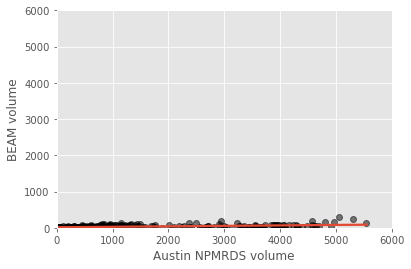

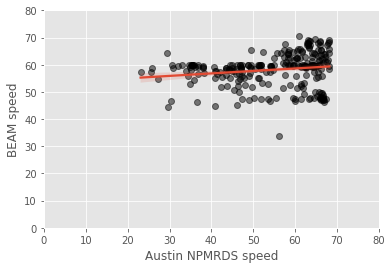

In [16]:
sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS volume", y="BEAM volume",
           scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 6000])
plt.ylim([0, 6000])
plt.savefig('plot/paired_NPMRDS_screenline_volume_validation.png', dpi = 200)
plt.show()
sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS speed", y="BEAM speed",
           scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 80])
plt.ylim([0, 80])
plt.savefig('plot/paired_NPMRDS_screenline_speed_validation.png', dpi = 200)
plt.show()

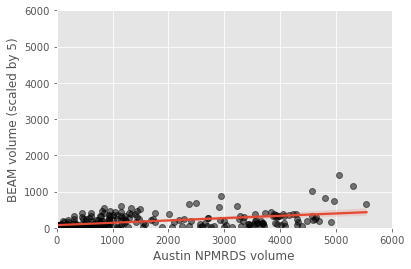

In [17]:
paired_data_for_comparison.loc[:, 'BEAM volume (scaled by 5)'] = paired_data_for_comparison.loc[:, 'BEAM volume'] * 5
sns.regplot(data=paired_data_for_comparison, x="Austin NPMRDS volume", y='BEAM volume (scaled by 5)',
           scatter_kws={"color": "black", 'alpha':0.5})
plt.xlim([0, 6000])
plt.ylim([0, 6000])
plt.savefig('plot/paired_NPMRDS_screenline_scaled_volume_validation.png', dpi = 200)
plt.show()

In [20]:
model_network_with_observed_traffic = pd.merge(model_network, austin_NPMRDS_data_hourly_data, 
                                               on = 'Tmc', how = 'left')
model_network_with_observed_traffic.loc[:, 'Volume(veh/hour)'] = model_network_with_observed_traffic.loc[:, 'Volume (veh/lane/hour)'] * \
model_network_with_observed_traffic.loc[:, 'numberOfLanes']
list_of_out_var = ['linkId', 'linkLength', 'linkFreeSpeed', 'linkCapacity', 
                   'numberOfLanes', 'linkModes', 'attributeOrigId',
                   'attributeOrigType', 'fromNodeId', 'toNodeId', 'name',
                   'hour', 'Avg.Speed (mph)', 'Volume(veh/hour)', 'source']
model_network_with_observed_traffic = model_network_with_observed_traffic.loc[:, list_of_out_var]
model_network_with_observed_traffic = model_network_with_observed_traffic.dropna()
model_network_with_observed_traffic.to_csv('sample output/AUS2010/observed_data_for_validation_part_2.csv', index = False)
model_network_with_observed_traffic.head(5)

,linkId,linkLength,linkFreeSpeed,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,hour,Avg.Speed (mph),Volume(veh/hour),source
140,8246,29.58,22.12848,2200,1.0,car;walk;bike,15110034,secondary,3396,5344,Bastrop,0.0,63.788935,78.222222,NPMRDS
141,8246,29.58,22.12848,2200,1.0,car;walk;bike,15110034,secondary,3396,5344,Bastrop,1.0,63.493312,50.360000,NPMRDS
142,8246,29.58,22.12848,2200,1.0,car;walk;bike,15110034,secondary,3396,5344,Bastrop,2.0,60.595860,40.680000,NPMRDS
143,8246,29.58,22.12848,2200,1.0,car;walk;bike,15110034,secondary,3396,5344,Bastrop,3.0,62.184545,42.086957,NPMRDS
144,8246,29.58,22.12848,2200,1.0,car;walk;bike,15110034,secondary,3396,5344,Bastrop,4.0,64.528024,82.666667,NPMRDS
